In [1]:
import pandas as pd
from astroquery.simbad import Simbad
from jwst import *

%load_ext autoreload
%autoreload 2


#assumes your target is in Tim Pearce's CSV File
target_name = 'HD61005'

df = pd.read_csv('../allDiscAnalysisResults.csv')
data_arr = df[['Target','Distance_pc','Age_Myr','PearceMPlt_MJup', 'PearcePltApocentre_arcsec','DiscInnerEdgePeri_au','DiscOuterEdgeApo_au']].to_numpy()
target_dict={}
for row in data_arr:
    target_dict[row[0]]=row[1:]

distance,age,planet_mass,separation,disk_inner_edge,disk_outer_edge = target_dict[target_name]

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Query Simbad for Spectral type and K-mag

In [2]:
Simbad.add_votable_fields('flux(K)','sp')
result_table = Simbad.query_object(target_name)
kmag,spt = result_table['FLUX_K'][0], result_table['SP_TYPE'][0]

Query all targets to and force spectral types

In [3]:
targets=df['Target'].to_numpy()
queried_params=[];spts=[]
for target in targets:
    result_table = Simbad.query_object(target)
    spts.append(result_table['SP_TYPE'][0])
    queried_params.append([target,result_table['FLUX_K'][0]])

In [4]:
def match_spt(spt,lookuptable=lookuptable):
    available_keys=list(lookuptable.keys())
    matches=[];diffs=[]
    for key in available_keys:
        if spt[0]==key[0]:
            matches.append(key)
    for match in matches:
        diffs.append(np.abs(int(spt[1])-int(match[1])))
    forced_spt= spt[0] + str(matches[np.where(diffs==np.min(diffs))[0][0]])[1]+'V'
    return forced_spt

spts[40]='A5V'
spts[103]='A1V'
for i,spt in enumerate(spts):
    if spt not in lookuptable: 
        spts[i] = match_spt(spt)
[params.append(spts[i]) for i, params in  enumerate(queried_params)]

#adding another dictionary to hold these queried paramters in a more useful format
simbad_vals={}
for star in queried_params:
    simbad_vals[star[0]]=[star[1],star[2]]


In [6]:
os.environ['PYSYN_CDBS']='/Users/connorvancil/Desktop/AstroResearch/Data/trds/'

instrument='nircam'
instrument_mask = 'mask335r'
jwst_filt = 'f444w'

kmag,spt = simbad_vals[target_name]

tst = get_jwst_mag(spt,kmag,instrument,jwst_filt,filter_dir="./",jwst_mask=instrument_mask,
                norm_filter='bessel_k')
print(tst)

6.4592444324903 VEGAMAG


In [7]:
filter_list = ['f250m','f300m','f356w','f410m','f444w','f1140c','f1550c']
instrument='nircam'
instrument_mask = 'mask335r'
jwst_filt = 'f444w'


configs = {'f250m':  {'instrument':'nircam','instrument_mask':'mask335r'},
            'f300m': {'instrument':'nircam','instrument_mask':'mask335r'}, 
            'f356w': {'instrument':'nircam','instrument_mask':'mask335r'},
            'f410m': {'instrument':'nircam','instrument_mask':'mask335r'},
            'f444w': {'instrument':'nircam','instrument_mask':'mask335r'},
            'f1140c':{'instrument':'miri',  'instrument_mask':None},
            'f1550c':{'instrument':'miri',  'instrument_mask':None},
            }
filter_list = list(configs.keys())

In [9]:
full_detection_list = []

for i, target in enumerate(targets):
    
    age = target_dict[target][1]
    distance = target_dict[target][0]
    comp_sep = target_dict[target][3] #Companion separation in arcseconds
    comp_mass = target_dict[target][2] #Companions mass in M_Jup

    disk_inner_edge = target_dict[target][4]/distance
    disk_outer_edge = target_dict[target][5]/distance
    
    kmag,spt = simbad_vals[target]
    
    mass_limits_list = []
    sep_list = []
    target_detection_array = []
    almost_detected_array = []

    print("Target: {}, {} Myr, {} pc, kmag={:.1f}".format(target,age,distance,kmag))

    if comp_sep < 0.3:
        print("\tCompanion separation for {} is < 0.3 arcseconds, skipping".format(target))
        continue

    for filter_name in filter_list:
        
        instrument = configs[filter_name]['instrument']
        instrument_mask = configs[filter_name]['instrument_mask']

        jwst_mag = get_jwst_mag(spt,kmag,instrument,filter_name,filter_dir="./",jwst_mask=instrument_mask,
                    norm_filter='bessel_k').value

        contrast_curves=read_contrast_curves()
        sep,companion_mags=companion_detection_limit(jwst_mag,filter_name,contrast_curves,plot=False);

        if comp_sep < np.min(sep):
            print("\tCompanion for {} is closer than the IWA in {}, skipping".format(target,filter_name))
            continue

        model_dir="/Users/connorvancil/Desktop/AstroResearch/Data/models/evolutionary_tracks/ATMO_CEQ/"
        model_dir+=model_instrument_directories.get(instrument.lower())
        
        if instrument.lower () == "nircam":
            model_dir+=model_nircam_mask_directories.get(instrument_mask.lower())


        mass_limits = generate_mass_curve(age,distance,companion_mags,filter_name,sep,model_dir,plot=False)

        detected = detect_companion(sep,mass_limits,comp_sep,comp_mass)
        target_detection_array.append(detected)

        #What if we got 2x deeper?
        almost_detected = detect_companion(sep,mass_limits/2.,comp_sep,comp_mass)
        almost_detected_array.append(almost_detected)

        # print("Was the companion detected? {}".format())
        mass_limits_list.append(mass_limits)
        sep_list.append(sep)

    if np.any(target_detection_array):
        print("\tCOMPANION DETECTED!")
        full_detection_list.append(True)
        figure_directory = "./Figures/Detected/"
    elif np.any(almost_detected_array): 
        full_detection_list.append(False)
        figure_directory = "./Figures/Almost_Detected/"
    else: 
        full_detection_list.append(False)
        figure_directory = "./Figures/Non-Detected/"
    
    fig,axis = plt.subplots(1,1,figsize=(12,5))
    for i in range(len(mass_limits_list)):
        plt.semilogy(sep_list[i],mass_limits_list[i],label=filter_list[i])
    plt.title("{}, {} Myr, {} pc, kmag={:.1f}, Detected: {}".format(target,age,distance,kmag,full_detection_list[-1]))
    plt.scatter(comp_sep,comp_mass,label="Predicted Companion")

    ymin, ymax = axis.get_ylim()

    plt.fill_between([disk_inner_edge,disk_outer_edge],[ymin],y2=[ymax],color='k',alpha=0.1)
    plt.xlabel("Separation (arcseconds)")
    plt.ylabel(r"Mass Limit ($M_{Jup}$)")
    plt.legend()
    plt.savefig(figure_directory+target+".png",dpi=200)
    plt.close()

        

Target: CD-522472, 50.0 Myr, 152.58 pc, kmag=8.7
	Companion separation for CD-522472 is < 0.3 arcseconds, skipping
Target: CPD-722713, 24.0 Myr, 36.62 pc, kmag=6.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: GJ581, 5000.0 Myr, 6.3 pc, kmag=5.8


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: GJ649, 4500.0 Myr, 10.38 pc, kmag=5.6


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD166, 250.0 Myr, 13.77 pc, kmag=4.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD203, 24.0 Myr, 39.91 pc, kmag=5.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD203 is closer than the IWA in f1550c, skipping
Target: HD377, 220.0 Myr, 38.48 pc, kmag=6.1


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD870, 3000.0 Myr, 20.62 pc, kmag=5.4


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD1404, 450.0 Myr, 42.03 pc, kmag=4.4


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD1461, 6000.0 Myr, 23.45 pc, kmag=4.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD1466, 45.0 Myr, 42.92 pc, kmag=6.1
	Companion separation for HD1466 is < 0.3 arcseconds, skipping
Target: HD2262, 650.0 Myr, 22.25 pc, kmag=3.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD3003, 45.0 Myr, 45.84 pc, kmag=5.0


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD3003 is closer than the IWA in f1140c, skipping
	Companion for HD3003 is closer than the IWA in f1550c, skipping
Target: HD3296, 1400.0 Myr, 44.85 pc, kmag=5.6


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD3670, 42.0 Myr, 77.42 pc, kmag=7.1


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD5133, 2500.0 Myr, 13.97 pc, kmag=4.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD7570, 4000.0 Myr, 15.17 pc, kmag=3.7


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD8907, 500.0 Myr, 33.19 pc, kmag=5.4


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD9672, 45.0 Myr, 56.98 pc, kmag=5.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD10008, 24.0 Myr, 24.03 pc, kmag=5.8


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD10472, 42.0 Myr, 71.01 pc, kmag=6.6


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD10647, 1700.0 Myr, 17.34 pc, kmag=4.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD10700, 6000.0 Myr, 3.6 pc, kmag=1.7


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD11171, 1000.0 Myr, 23.27 pc, kmag=3.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD12039, 45.0 Myr, 41.36 pc, kmag=6.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD12039 is closer than the IWA in f1140c, skipping
	Companion for HD12039 is closer than the IWA in f1550c, skipping
Target: HD13161, 780.0 Myr, 38.9 pc, kmag=2.7


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD13161 is closer than the IWA in f1140c, skipping
	Companion for HD13161 is closer than the IWA in f1550c, skipping
Target: HD13246, 45.0 Myr, 45.55 pc, kmag=6.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD15115, 45.0 Myr, 48.93 pc, kmag=5.8


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD16743, 45.0 Myr, 57.84 pc, kmag=5.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD17094, 1500.0 Myr, 26.488000000000003 pc, kmag=3.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD17925, 200.0 Myr, 10.355 pc, kmag=4.1


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD17925 is closer than the IWA in f1550c, skipping
Target: HD19668, 149.0 Myr, 38.66 pc, kmag=6.7
	Companion separation for HD19668 is < 0.3 arcseconds, skipping
Target: HD21997, 42.0 Myr, 69.5 pc, kmag=6.1


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD22049, 800.0 Myr, 3.2030000000000003 pc, kmag=1.7


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD22484, 5000.0 Myr, 13.96 pc, kmag=2.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD22484 is closer than the IWA in f1550c, skipping
Target: HD23356, 1500.0 Myr, 13.949000000000002 pc, kmag=4.8


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD23484, 3500.0 Myr, 16.162 pc, kmag=4.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD25457, 149.0 Myr, 18.76 pc, kmag=4.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD27045, 300.0 Myr, 29.289 pc, kmag=4.4


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD27290, 1500.0 Myr, 20.44 pc, kmag=3.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD28355, 750.0 Myr, 48.507 pc, kmag=4.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD28355 is closer than the IWA in f1550c, skipping
Target: HD29391, 700.0 Myr, 29.758000000000003 pc, kmag=4.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD30422, 700.0 Myr, 57.38 pc, kmag=5.7


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD30422 is closer than the IWA in f1550c, skipping
Target: HD30447, 42.0 Myr, 80.35 pc, kmag=6.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD30495, 45.0 Myr, 13.24 pc, kmag=4.0


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD31295, 200.0 Myr, 34.224000000000004 pc, kmag=4.4


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD32297, 100.0 Myr, 132.3 pc, kmag=7.6


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD32297 is closer than the IWA in f1550c, skipping
Target: HD32977, 350.0 Myr, 61.87 pc, kmag=5.0


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD32977 is closer than the IWA in f1550c, skipping
Target: HD35114, 40.0 Myr, 47.6 pc, kmag=6.1


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD35114 is closer than the IWA in f1140c, skipping
	Companion for HD35114 is closer than the IWA in f1550c, skipping
Target: HD35850, 24.0 Myr, 26.86 pc, kmag=4.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD36968, 35.0 Myr, 149.46 pc, kmag=8.1


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD36968 is closer than the IWA in f1550c, skipping
Target: HD37484, 42.0 Myr, 59.01 pc, kmag=6.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD38206, 42.0 Myr, 71.26 pc, kmag=5.8


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD38397, 42.0 Myr, 53.73 pc, kmag=6.8


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD38397 is closer than the IWA in f1550c, skipping
Target: HD38678, 300.0 Myr, 21.86 pc, kmag=3.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD40136, 1500.0 Myr, 14.5 pc, kmag=2.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD43989, 42.0 Myr, 51.93 pc, kmag=6.6
	Companion separation for HD43989 is < 0.3 arcseconds, skipping
Target: HD46190, 180.0 Myr, 84.31 pc, kmag=6.4
	Companion separation for HD46190 is < 0.3 arcseconds, skipping
Target: HD48370, 60.0 Myr, 36.03 pc, kmag=6.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD48682, 4000.0 Myr, 16.64 pc, kmag=4.1


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD50554, 4000.0 Myr, 31.166 pc, kmag=5.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD53143, 1000.0 Myr, 18.35 pc, kmag=5.0


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD58715, 215.0 Myr, 49.41 pc, kmag=3.0
	Companion separation for HD58715 is < 0.3 arcseconds, skipping
Target: HD59967, 450.0 Myr, 21.76 pc, kmag=5.1


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD61005, 45.0 Myr, 36.45 pc, kmag=6.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD69830, 6000.0 Myr, 12.559 pc, kmag=4.2
	Companion separation for HD69830 is < 0.3 arcseconds, skipping
Target: HD70313, 250.0 Myr, 52.02 pc, kmag=5.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD71043, 45.0 Myr, 73.1 pc, kmag=5.9
	Companion separation for HD71043 is < 0.3 arcseconds, skipping
Target: HD71155, 250.0 Myr, 36.36 pc, kmag=3.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD72905, 250.0 Myr, 14.445 pc, kmag=4.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD75616, 1000.0 Myr, 35.787 pc, kmag=5.7


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD76151, 2000.0 Myr, 16.84 pc, kmag=4.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD85364, 800.0 Myr, 65.127 pc, kmag=5.6


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD87696, 750.0 Myr, 26.985 pc, kmag=4.0


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD87696 is closer than the IWA in f1550c, skipping
Target: HD90905, 350.0 Myr, 31.01 pc, kmag=5.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD92536, 46.0 Myr, 157.3 pc, kmag=6.5
	Companion separation for HD92536 is < 0.3 arcseconds, skipping
Target: HD92945, 250.0 Myr, 21.53 pc, kmag=5.7


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD95418, 414.0 Myr, 29.61 pc, kmag=2.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD95418 is closer than the IWA in f1550c, skipping
Target: HD102458, 15.0 Myr, 113.03 pc, kmag=7.5
	Companion separation for HD102458 is < 0.3 arcseconds, skipping
Target: HD102647, 45.0 Myr, 11.0 pc, kmag=1.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD102647 is closer than the IWA in f1550c, skipping
Target: HD103234, 15.0 Myr, 101.83 pc, kmag=7.3
	Companion separation for HD103234 is < 0.3 arcseconds, skipping
Target: HD103703, 15.0 Myr, 107.1 pc, kmag=7.4
	Companion separation for HD103703 is < 0.3 arcseconds, skipping
Target: HD104231, 15.0 Myr, 102.43 pc, kmag=7.4
	Companion separation for HD104231 is < 0.3 arcseconds, skipping
Target: HD104860, 250.0 Myr, 45.142 pc, kmag=6.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD105613, 15.0 Myr, 104.29 pc, kmag=7.0
	Companion separation for HD105613 is < 0.3 arcseconds, skipping
Target: HD107146, 150.0 Myr, 27.45 pc, kmag=5.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD107649, 15.0 Myr, 107.99 pc, kmag=7.7
	Companion separation for HD107649 is < 0.3 arcseconds, skipping
Target: HD109085, 1500.0 Myr, 17.955 pc, kmag=3.4


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD109832, 15.0 Myr, 107.98 pc, kmag=7.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD109832 is closer than the IWA in f1550c, skipping
Target: HD110058, 15.0 Myr, 129.52 pc, kmag=7.6
	Companion separation for HD110058 is < 0.3 arcseconds, skipping
Target: HD110411, 300.0 Myr, 38.13 pc, kmag=4.7


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD110634, 15.0 Myr, 124.41 pc, kmag=7.7
	Companion separation for HD110634 is < 0.3 arcseconds, skipping
Target: HD110897, 6000.0 Myr, 17.555999999999997 pc, kmag=4.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD111103, 15.0 Myr, 130.37 pc, kmag=8.1
	Companion separation for HD111103 is < 0.3 arcseconds, skipping
Target: HD111520, 15.0 Myr, 108.6 pc, kmag=7.7


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD111520 is closer than the IWA in f1140c, skipping
	Companion for HD111520 is closer than the IWA in f1550c, skipping
Target: HD111631, 600.0 Myr, 10.65 pc, kmag=4.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD112429, 1400.0 Myr, 29.363000000000003 pc, kmag=4.4


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD113337, 1500.0 Myr, 36.18 pc, kmag=5.0


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD113524, 15.0 Myr, 118.94 pc, kmag=7.9
	Companion separation for HD113524 is < 0.3 arcseconds, skipping
Target: HD113556, 15.0 Myr, 101.25 pc, kmag=7.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD114082, 15.0 Myr, 95.39 pc, kmag=7.2
	Companion separation for HD114082 is < 0.3 arcseconds, skipping
Target: HD115617, 4000.0 Myr, 8.51 pc, kmag=3.0


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD115820, 15.0 Myr, 115.52 pc, kmag=7.3
	Companion separation for HD115820 is < 0.3 arcseconds, skipping
Target: HD115892, 200.0 Myr, 17.84 pc, kmag=2.7


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD120326, 15.5 Myr, 113.6 pc, kmag=7.5
	Companion separation for HD120326 is < 0.3 arcseconds, skipping
Target: HD121191, 15.5 Myr, 131.61 pc, kmag=7.7
	Companion separation for HD121191 is < 0.3 arcseconds, skipping
Target: HD121617, 15.5 Myr, 116.49 pc, kmag=7.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD121617 is closer than the IWA in f1140c, skipping
	Companion for HD121617 is closer than the IWA in f1550c, skipping
Target: HD123889, 16.0 Myr, 127.96 pc, kmag=7.7
	Companion separation for HD123889 is < 0.3 arcseconds, skipping
Target: HD125162, 300.0 Myr, 30.314 pc, kmag=3.9
	Companion separation for HD125162 is < 0.3 arcseconds, skipping
Target: HD125451, 1400.0 Myr, 26.209 pc, kmag=4.4


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD125541, 16.0 Myr, 159.83 pc, kmag=8.1
	Companion separation for HD125541 is < 0.3 arcseconds, skipping
Target: HD126062, 16.0 Myr, 132.0 pc, kmag=7.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD127762, 900.0 Myr, 26.719 pc, kmag=2.6


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD127821, 1300.0 Myr, 31.683000000000003 pc, kmag=5.0


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD128311, 500.0 Myr, 16.329 pc, kmag=5.1


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD131511, 1000.0 Myr, 11.37 pc, kmag=4.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD131835, 16.0 Myr, 133.3 pc, kmag=7.5
	Companion separation for HD131835 is < 0.3 arcseconds, skipping
Target: HD134888, 16.0 Myr, 111.97 pc, kmag=7.7


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD134888 is closer than the IWA in f1140c, skipping
	Companion for HD134888 is closer than the IWA in f1550c, skipping
Target: HD135379, 500.0 Myr, 28.415 pc, kmag=3.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD135599, 1200.0 Myr, 15.808 pc, kmag=5.0


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD135953, 16.0 Myr, 130.0 pc, kmag=8.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD135953 is closer than the IWA in f1140c, skipping
	Companion for HD135953 is closer than the IWA in f1550c, skipping
Target: HD138813, 10.0 Myr, 136.9 pc, kmag=7.2
	Companion separation for HD138813 is < 0.3 arcseconds, skipping
Target: HD139006, 300.0 Myr, 23.67 pc, kmag=2.2
	Companion separation for HD139006 is < 0.3 arcseconds, skipping
Target: HD139664, 200.0 Myr, 17.38 pc, kmag=3.8


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD141943, 16.0 Myr, 60.24 pc, kmag=6.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD141943 is closer than the IWA in f1550c, skipping
Target: HD143894, 500.0 Myr, 51.349 pc, kmag=4.6


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD145689, 45.0 Myr, 55.47 pc, kmag=5.7
	Companion separation for HD145689 is < 0.3 arcseconds, skipping
Target: HD145964, 10.0 Myr, 111.92 pc, kmag=6.4


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD145972, 16.0 Myr, 125.44 pc, kmag=7.6
	Companion separation for HD145972 is < 0.3 arcseconds, skipping
Target: HD146181, 16.0 Myr, 124.53 pc, kmag=8.1


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD146181 is closer than the IWA in f1550c, skipping
Target: HD146624, 250.0 Myr, 43.44 pc, kmag=4.7


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD146624 is closer than the IWA in f1550c, skipping
Target: HD146897, 10.0 Myr, 131.01 pc, kmag=7.8


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD146897 is closer than the IWA in f1140c, skipping
	Companion for HD146897 is closer than the IWA in f1550c, skipping
Target: HD152598, 200.0 Myr, 29.646 pc, kmag=4.6


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD156623, 16.0 Myr, 111.41 pc, kmag=7.0
	Companion separation for HD156623 is < 0.3 arcseconds, skipping
Target: HD161868, 300.0 Myr, 30.031 pc, kmag=3.7


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD166348, 3500.0 Myr, 13.2 pc, kmag=5.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD169022, 130.0 Myr, 43.94 pc, kmag=1.8


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD172555, 24.0 Myr, 28.32 pc, kmag=4.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD172555 is closer than the IWA in f1140c, skipping
	Companion for HD172555 is closer than the IWA in f1550c, skipping
Target: HD179520, 300.0 Myr, 58.58 pc, kmag=6.1
	Companion separation for HD179520 is < 0.3 arcseconds, skipping
Target: HD181296, 24.0 Myr, 47.3 pc, kmag=5.0


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD181327, 24.0 Myr, 48.15 pc, kmag=5.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD182919, 200.0 Myr, 71.839 pc, kmag=5.6
	Companion separation for HD182919 is < 0.3 arcseconds, skipping
Target: HD183324, 500.0 Myr, 60.574 pc, kmag=5.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD188228, 45.0 Myr, 31.36 pc, kmag=3.8


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD191089, 24.0 Myr, 50.06 pc, kmag=6.1


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD191089 is closer than the IWA in f1550c, skipping
Target: HD191174, 390.0 Myr, 83.368 pc, kmag=6.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD191849, 900.0 Myr, 6.159 pc, kmag=4.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD192425, 400.0 Myr, 47.913 pc, kmag=4.8


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD192758, 45.0 Myr, 66.4 pc, kmag=6.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD192758 is closer than the IWA in f1550c, skipping
Target: HD193571, 205.0 Myr, 68.34 pc, kmag=5.6


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD196544, 130.0 Myr, 59.37 pc, kmag=5.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD197481, 24.0 Myr, 9.72 pc, kmag=4.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD199260, 400.0 Myr, 21.27 pc, kmag=4.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD202628, 1100.0 Myr, 23.81 pc, kmag=5.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD205811, 380.0 Myr, 88.08 pc, kmag=6.1


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD205811 is closer than the IWA in f1140c, skipping
	Companion for HD205811 is closer than the IWA in f1550c, skipping
Target: HD206860, 400.0 Myr, 18.119 pc, kmag=4.6


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD207129, 3000.0 Myr, 15.55 pc, kmag=4.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD209253, 600.0 Myr, 31.39 pc, kmag=5.4


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD213398, 180.0 Myr, 43.13 pc, kmag=4.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD213617, 700.0 Myr, 53.495 pc, kmag=5.6


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD215766, 100.0 Myr, 108.57 pc, kmag=5.7


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD215766 is closer than the IWA in f1140c, skipping
	Companion for HD215766 is closer than the IWA in f1550c, skipping
Target: HD216435, 5000.0 Myr, 32.98 pc, kmag=4.6


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD218340, 1100.0 Myr, 56.09 pc, kmag=6.9


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD218396, 42.0 Myr, 41.24 pc, kmag=5.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: HD218511, 1000.0 Myr, 14.83 pc, kmag=5.3


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD219482, 430.0 Myr, 20.45 pc, kmag=4.4


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD219482 is closer than the IWA in f1140c, skipping
	Companion for HD219482 is closer than the IWA in f1550c, skipping
Target: HD219498, 300.0 Myr, 56.99 pc, kmag=7.4


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD219498 is closer than the IWA in f1550c, skipping
Target: HD220825, 149.0 Myr, 48.861 pc, kmag=5.0


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD220825 is closer than the IWA in f1550c, skipping
Target: HD221853, 100.0 Myr, 65.292 pc, kmag=6.4


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD222368, 5000.0 Myr, 13.43 pc, kmag=2.8


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD223340, 149.0 Myr, 44.18 pc, kmag=7.1


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


Target: HD223352, 149.0 Myr, 42.71 pc, kmag=4.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HD223352 is closer than the IWA in f1550c, skipping
Target: HIP6276, 149.0 Myr, 35.296 pc, kmag=6.5


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	Companion for HIP6276 is closer than the IWA in f1550c, skipping
Target: MML8, 15.0 Myr, 112.92 pc, kmag=8.1
	Companion separation for MML8 is < 0.3 arcseconds, skipping
Target: MML28, 15.0 Myr, 117.46 pc, kmag=8.8
	Companion separation for MML28 is < 0.3 arcseconds, skipping
Target: MML36, 16.0 Myr, 99.51 pc, kmag=7.9
	Companion separation for MML36 is < 0.3 arcseconds, skipping
Target: NLTT54872, 440.0 Myr, 7.672999999999999 pc, kmag=7.2


/Users/connorvancil/Desktop/AstroResearch/contraster/testing/models.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


	COMPANION DETECTED!
Target: SAO150676, 42.0 Myr, 72.99 pc, kmag=7.5
	Companion separation for SAO150676 is < 0.3 arcseconds, skipping


In [21]:
disk_outer_edge

5.024576734025123

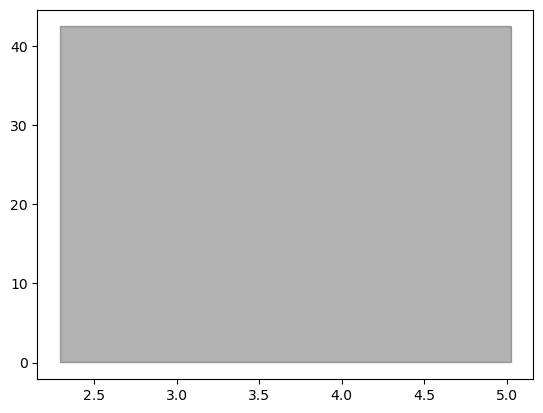

In [26]:
plt.fill_between([disk_inner_edge,disk_outer_edge],[ymin],y2=[ymax],color='k',alpha=0.3)

In [12]:
len(np.where(full_detection_list)[0])

20

In [53]:
bex_dir = "/Users/connorvancil/Desktop/AstroResearch/Data/models/cooling_curves/"
any_file = glob.glob(bex_dir+"*.dat")[19]
with open(any_file, 'r') as f:
        lines = f.read().splitlines()
        header = lines[0:3]#.replace('#','').lower().split()
        data = lines[3:]
        []
                
header
data

['         6.0         5.0       0.717       5.649     178.326       1.881       39.91       37.79       42.48       24.10       19.45       42.73       40.37       28.56       19.75       17.75       14.81       40.16       38.13       42.81       32.30       26.39       20.01       22.62       20.58       20.40       18.58       16.23       15.52       14.98       14.67       19.33       18.25       43.32       40.02       37.70       42.26       48.86       38.15       36.00       42.31       41.80       43.54',
 '         6.1         5.0       0.703       5.155     175.915       1.897       40.24       38.07       42.98       24.27       19.58       42.88       40.55       28.78       19.88       17.85       14.89       40.49       38.40       43.31       32.47       26.60       20.15       22.80       20.71       20.59       18.73       16.32       15.60       15.06       14.75       19.46       18.38       43.74       40.36       37.98       42.74       49.26       38.49       36

In [42]:
header[2]

' #1:log(Age/yr), 2:Mass/Mearth, 3:Radius/Rjupiter, 4:Luminosity/Ljupiter, 5:Teff/K, 6:logg/cgs, 7:NACOJ, 8:NACOH, 9:NACOKs, 10:NACOLp, 11:NACOMp, 12:CousinsR, 13:CousinsI, 14:WISE1, 15:WISE2, 16:WISE3, 17:WISE4, 18:F115W, 19:F150W, 20:F200W, 21:F277W, 22:F356W, 23:F444W, 24:F560W, 25:F770W, 26:F1000W, 27:F1280W, 28:F1500W, 29:F1800W, 30:F2100W, 31:F2550W, 32:VISIRB87, 33:VISIRSiC, 34:SPHEREY, 35:SPHEREJ, 36:SPHEREH, 37:SPHEREKs, 38:SPHEREJ2, 39:SPHEREJ3, 40:SPHEREH2, 41:SPHEREH3, 42:SPHEREK1, 43:SPHEREK2\n'

In [48]:
data

['         6.0         5.0       0.717       5.649     178.326       1.881       39.91       37.79       42.48       24.10       19.45       42.73       40.37       28.56       19.75       17.75       14.81       40.16       38.13       42.81       32.30       26.39       20.01       22.62       20.58       20.40       18.58       16.23       15.52       14.98       14.67       19.33       18.25       43.32       40.02       37.70       42.26       48.86       38.15       36.00       42.31       41.80       43.54\n',
 '         6.1         5.0       0.703       5.155     175.915       1.897       40.24       38.07       42.98       24.27       19.58       42.88       40.55       28.78       19.88       17.85       14.89       40.49       38.40       43.31       32.47       26.60       20.15       22.80       20.71       20.59       18.73       16.32       15.60       15.06       14.75       19.46       18.38       43.74       40.36       37.98       42.74       49.26       38.49       